In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Testing whether GPU is working or not
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
file = open('/content/drive/MyDrive/ML_A2_DATA/train.txt', 'r')
data = []

for l in file:
  i = l.split()
  data.append(i)

data[0]

['mr', 'hoagie', 'is', 'an', 'institution', '.']

In [4]:
type(data[0])

list

In [5]:
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token
    OOV_token = 2   # Out-of-Vocabulary token

    def __init__(self, name=""):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {Vocabulary.PAD_token: "PAD_Token", Vocabulary.SOS_token: "SOS_Token", Vocabulary.EOS_token: "EOS_Token", Vocabulary.OOV_token: "OOV_Token"}
        self.num_words = 4
        self.num_sentences = 0
        self.longest_sentence = 0

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence:
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]



In [6]:
totalwords = []
for i in data:
  totalwords += i
o = Vocabulary()
o.add_sentence(totalwords)
data_vocabulary = o.word2count

In [7]:
import operator
import itertools
sorted_dict = dict(sorted(data_vocabulary.items(), key=operator.itemgetter(1), reverse=True))
top_k = 1000
top_k_dict = dict(itertools.islice(sorted_dict.items(), top_k))
top_k_dict['PAD_Token'] = 0
top_k_dict['SOS_Token'] = 0
top_k_dict['EOS_Token'] = 0
top_k_dict['OOV_Token'] = 0

In [8]:
index_dict = {'PAD_Token':0,'SOS_Token':1,'EOS_Token':2,'OOV_Token':3}
j=4
for i in sorted_dict:
  index_dict[i] = j
  j+=1

In [9]:
vector_embedding = np.zeros((len(sorted_dict)+4 , len(top_k_dict)), dtype="int8")
for k,v in index_dict.items():
  if k in top_k_dict:
    vector_embedding[v][v]=1
  else:
    vector_embedding[v][index_dict['OOV_Token']] = 1

In [10]:
import copy
input_text = copy.deepcopy(data)
output_text = copy.deepcopy(data)
max_length = max([len(i) for i in data])



for i in range(len(input_text)):
  if max_length <= len(input_text[i]):
    input_text[i] = input_text[i][0:max_length - 1]
  input_text[i].append('EOS_Token')

  output_text[i].insert(0,'SOS_Token')
  if max_length <= len(output_text[i]):
    output_text[i] = output_text[i][0:max_length - 1]
  output_text[i].append('EOS_Token')

In [11]:
print(data[0])
print(input_text[0])
print(output_text[0])

['mr', 'hoagie', 'is', 'an', 'institution', '.']
['mr', 'hoagie', 'is', 'an', 'institution', '.', 'EOS_Token']
['SOS_Token', 'mr', 'hoagie', 'is', 'an', 'institution', '.', 'EOS_Token']


In [12]:
encoder_input_data=[]
decoder_input_data=[]
decoder_target_data = []

for i in range(len(input_text)):
  temp1 = []
  count = 0
  for j in input_text[i]:
    if j in top_k_dict:
      temp1.append(vector_embedding[index_dict[j]])
    else:
      j='OOV_Token'
      temp1.append(vector_embedding[index_dict['OOV_Token']])
    count+=1
    if j=='EOS_Token' or count >= max_length:
      break
  while max_length - count != 0 :
    temp1.append(vector_embedding[index_dict['PAD_Token']])
    count+=1
  encoder_input_data.append(temp1)

  temp1 = []
  count = 0
  for j in output_text[i]:
    if j in top_k_dict:
      temp1.append(vector_embedding[index_dict[j]])
    else:
      j='OOV_Token'
      temp1.append(vector_embedding[index_dict['OOV_Token']])
    count+=1
    if j=='EOS_Token' or count >= max_length:
      break
  while max_length - count != 0 :
    temp1.append(vector_embedding[index_dict['PAD_Token']])
    count+=1
  decoder_input_data.append(temp1)

for i in output_text:
  i.pop(0)



for i in range(len(output_text)):
  temp1 = []
  count = 0
  for j in output_text[i]:
    if j in top_k_dict:
      temp1.append(vector_embedding[index_dict[j]])
    else:
      j='OOV_Token'
      temp1.append(vector_embedding[index_dict['OOV_Token']])
    count+=1
    if j=='EOS_Token' or count >= max_length:
      break
  while max_length - count != 0 :
    temp1.append(vector_embedding[index_dict['PAD_Token']])
    count+=1
  decoder_target_data.append(temp1)

encoder_input_data = np.array(encoder_input_data)
decoder_input_data = np.array(decoder_input_data)
decoder_target_data = np.array(decoder_target_data)

In [13]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_input_data.shape)

(200000, 15, 1004)
(200000, 15, 1004)
(200000, 15, 1004)


# **Uploading the validation data**

In [14]:
file = open('/content/drive/MyDrive/ML_A2_DATA/valid.txt', 'r')
valid_data = []

for l in file:
  i = l.split()
  valid_data.append(i)

import copy
input_text = copy.deepcopy(valid_data)
output_text = copy.deepcopy(valid_data)
max_length = max([len(i) for i in valid_data])
print(max_length , "maximum length for validation data")


for i in range(len(input_text)):
  if max_length <= len(input_text[i]):
    input_text[i] = input_text[i][0:max_length - 1]
  input_text[i].append('EOS_Token')

  output_text[i].insert(0,'SOS_Token')
  if max_length <= len(output_text[i]):
    output_text[i] = output_text[i][0:max_length - 1]
  output_text[i].append('EOS_Token')

valid_encoder_input_data=[]
valid_decoder_input_data=[]
valid_decoder_target_data = []

for i in range(len(input_text)):
  temp1 = []
  count = 0
  for j in input_text[i]:
    if j in top_k_dict:
      temp1.append(vector_embedding[index_dict[j]])
    else:
      j='OOV_Token'
      temp1.append(vector_embedding[index_dict['OOV_Token']])
    count+=1
    if j=='EOS_Token' or count >= max_length:
      break
  while max_length - count != 0 :
    temp1.append(vector_embedding[index_dict['PAD_Token']])
    count+=1
  valid_encoder_input_data.append(temp1)

  temp1 = []
  count = 0
  for j in output_text[i]:
    if j in top_k_dict:
      temp1.append(vector_embedding[index_dict[j]])
    else:
      j='OOV_Token'
      temp1.append(vector_embedding[index_dict['OOV_Token']])
    count+=1
    if j=='EOS_Token' or count >= max_length:
      break
  while max_length - count != 0 :
    temp1.append(vector_embedding[index_dict['PAD_Token']])
    count+=1
  valid_decoder_input_data.append(temp1)

for i in output_text:
  i.pop(0)



for i in range(len(output_text)):
  temp1 = []
  count = 0
  for j in output_text[i]:
    if j in top_k_dict:
      temp1.append(vector_embedding[index_dict[j]])
    else:
      j='OOV_Token'
      temp1.append(vector_embedding[index_dict['OOV_Token']])
    count+=1
    if j=='EOS_Token' or count >= max_length:
      break
  while max_length - count != 0 :
    temp1.append(vector_embedding[index_dict['PAD_Token']])
    count+=1
  valid_decoder_target_data.append(temp1)

valid_encoder_input_data = np.array(valid_encoder_input_data)
valid_decoder_input_data = np.array(valid_decoder_input_data)
valid_decoder_target_data = np.array(valid_decoder_target_data)

print(valid_encoder_input_data.shape)
print(valid_decoder_input_data.shape)
print(valid_decoder_input_data.shape)

15 maximum length for validation data
(10000, 15, 1004)
(10000, 15, 1004)
(10000, 15, 1004)


# **Bidirectional Model**

In [15]:
batch_size = 64

latent_dim = 100
initial_dim = 50
unique_tokens = len(top_k_dict)

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional , Concatenate

encoder_inputs = Input(shape=(None, unique_tokens))
encoder = Bidirectional(LSTM(initial_dim, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, unique_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(unique_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
batch_size = 64
epochs = 50

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model_data = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_data = ([valid_encoder_input_data, valid_decoder_input_data], valid_decoder_target_data), verbose = 1)

Epoch 1/50
3125/3125 [==============================] - 57s 11ms/step - loss: 2.8055 - accuracy: 0.5185 - val_loss: 1.5912 - val_accuracy: 0.7083
Epoch 2/50
3125/3125 [==============================] - 32s 10ms/step - loss: 1.4162 - accuracy: 0.7390 - val_loss: 0.9471 - val_accuracy: 0.8191
Epoch 3/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.8564 - accuracy: 0.8338 - val_loss: 0.6083 - val_accuracy: 0.8770
Epoch 4/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.5619 - accuracy: 0.8857 - val_loss: 0.4120 - val_accuracy: 0.9151
Epoch 5/50
3125/3125 [==============================] - 31s 10ms/step - loss: 0.3835 - accuracy: 0.9193 - val_loss: 0.2913 - val_accuracy: 0.9380
Epoch 6/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.2729 - accuracy: 0.9415 - val_loss: 0.2297 - val_accuracy: 0.9514
Epoch 7/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.2022 - accuracy: 0.9570 - val_loss: 0.1807 -

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1004)] 0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 100), (None, 422000      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1004)] 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 100)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]          

In [18]:
import keras

encoder_model = keras.Model(encoder_inputs, encoder_states)


decoder_state_input_h = keras.Input(shape=(latent_dim ,), name="input_8")
decoder_state_input_c = keras.Input(shape=(latent_dim ,), name="input_9")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_token_index = dict((i, token) for token, i in index_dict.items())
reverse_target_token_index = dict((i, token) for token, i in index_dict.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # print(states_value)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, unique_tokens))
    # Populate the first token of target sequence with the start token.
    target_seq[0, 0, index_dict['SOS_Token']] = 1.0

    
    stop_condition = False
    decoded_sentence = ""
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_token_index[sampled_token_index]
        decoded_sentence += sampled_token
        decoded_sentence += " "
        
        if sampled_token == 'EOS_Token' or len(decoded_sentence) >= max_length - 1:  # previously > max_length
            stop_condition = True

        
        target_seq = np.zeros((1, 1, unique_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        
        states_value = [h, c]
    return decoded_sentence

# **Part - a - Plot the validation loss per epoch.**

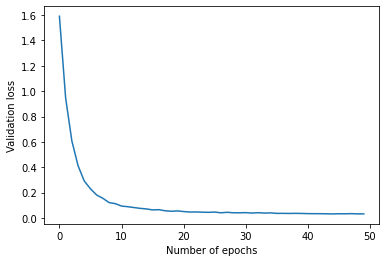

In [ ]:
from matplotlib import pyplot as plt

validation_loss = model_data.history['val_loss']
indices = range(epochs)
plt.plot(indices, validation_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Validation loss')
plt.show()

# **Part - b - Reconstruction Loss on test data**

# **Uploading the test data**

In [20]:
file = open('/content/drive/MyDrive/ML_A2_DATA/test.txt', 'r')
test_data = []

for l in file:
  i = l.split()
  test_data.append(i)

import copy
input_text = copy.deepcopy(test_data)
output_text = copy.deepcopy(test_data)
max_length = max([len(i) for i in test_data])
print(max_length , "maximum length for test data")


for i in range(len(input_text)):
  if max_length <= len(input_text[i]):
    input_text[i] = input_text[i][0:max_length - 1]
  input_text[i].append('EOS_Token')

  output_text[i].insert(0,'SOS_Token')
  if max_length <= len(output_text[i]):
    output_text[i] = output_text[i][0:max_length - 1]
  output_text[i].append('EOS_Token')

test_encoder_input_data=[]
test_decoder_input_data=[]
test_decoder_target_data=[]

for i in range(len(input_text)):
  temp1 = []
  count = 0
  for j in input_text[i]:
    if j in top_k_dict:
      temp1.append(vector_embedding[index_dict[j]])
    else:
      j='OOV_Token'
      temp1.append(vector_embedding[index_dict['OOV_Token']])
    count+=1
    if j=='EOS_Token' or count >= max_length:
      break
  while max_length - count != 0 :
    temp1.append(vector_embedding[index_dict['PAD_Token']])
    count+=1
  test_encoder_input_data.append(temp1)

  temp1 = []
  count = 0
  for j in output_text[i]:
    if j in top_k_dict:
      temp1.append(vector_embedding[index_dict[j]])
    else:
      j='OOV_Token'
      temp1.append(vector_embedding[index_dict['OOV_Token']])
    count+=1
    if j=='EOS_Token' or count >= max_length:
      break
  while max_length - count != 0 :
    temp1.append(vector_embedding[index_dict['PAD_Token']])
    count+=1
  test_decoder_input_data.append(temp1)

for i in output_text:
  i.pop(0)



for i in range(len(output_text)):
  temp1 = []
  count = 0
  for j in output_text[i]:
    if j in top_k_dict:
      temp1.append(vector_embedding[index_dict[j]])
    else:
      j='OOV_Token'
      temp1.append(vector_embedding[index_dict['OOV_Token']])
    count+=1
    if j=='EOS_Token' or count >= max_length:
      break
  while max_length - count != 0 :
    temp1.append(vector_embedding[index_dict['PAD_Token']])
    count+=1
  test_decoder_target_data.append(temp1)

test_encoder_input_data = np.array(test_encoder_input_data)
test_decoder_input_data = np.array(test_decoder_input_data)
test_decoder_target_data = np.array(test_decoder_target_data)

print(test_encoder_input_data.shape)
print(test_decoder_input_data.shape)
print(test_decoder_input_data.shape)

15 maximum length for test data
(10000, 15, 1004)
(10000, 15, 1004)
(10000, 15, 1004)


In [ ]:
values = model.evaluate([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data)
print("Reconstruction Loss = ", values[0])

313/313 [==============================] - 2s 6ms/step - loss: 0.0318 - accuracy: 0.9921
Reconstruction Loss =  0.03176264464855194


# **Part b - BLEU Score on test data**

In [29]:
target_file = open('/content/drive/MyDrive/ML_A2_DATA/predicted_file.txt' , 'w+')

for seq_index in range(len(test_encoder_input_data)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = test_encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    target_file.write(decoded_sentence)
    target_file.write("\n")


**Preprcessing the input file**

In [26]:
file = open('/content/drive/MyDrive/ML_A2_DATA/test.txt', 'r')

input_file = []
for l in file:
  l=l.split()
  review = ""
  for word in l:
    if word in index_dict:
      review += word
    else:
      review += "OOV_Token"
    review += " "
  input_file.append(review)

In [28]:
processed_file = open('/content/drive/MyDrive/ML_A2_DATA/processed_file.txt' , 'w+')

for i in input_file:
  processed_file.write(i)
  processed_file.write("\n")

In [ ]:
!pip install --upgrade bleu
!pip install --upgrade git+git://github.com/zhijing-jin/bleu.git

In [87]:
from bleu import file_bleu
file_bleu('/content/drive/MyDrive/ML_A2_DATA/processed_file.txt', '/content/drive/MyDrive/ML_A2_DATA/predicted_file.txt')

53.75


# **Extracting the data 1000.pos, 1000.neg, 100.pos, 100.neg**

In [53]:
def fetch_encoder_input_data(data):
  import copy
  input_text = copy.deepcopy(data)
  output_text = copy.deepcopy(data)
  max_length = max([len(i) for i in data])


  for i in range(len(input_text)):
    if max_length <= len(input_text[i]):
      input_text[i] = input_text[i][0:max_length - 1]
    input_text[i].append('EOS_Token')

    output_text[i].insert(0,'SOS_Token')
    if max_length <= len(output_text[i]):
      output_text[i] = output_text[i][0:max_length - 1]
    output_text[i].append('EOS_Token')

  encoder_input_data=[]
  

  for i in range(len(input_text)):
    temp1 = []
    count = 0
    for j in input_text[i]:
      if j in top_k_dict:
        temp1.append(vector_embedding[index_dict[j]])
      else:
        j='OOV_Token'
        temp1.append(vector_embedding[index_dict['OOV_Token']])
      count+=1
      if j=='EOS_Token' or count >= max_length:
        break
    while max_length - count != 0 :
      temp1.append(vector_embedding[index_dict['PAD_Token']])
      count+=1
    encoder_input_data.append(temp1)
    
  return encoder_input_data

file = open('/content/drive/MyDrive/ML_A2_DATA/1000.neg', 'r')
neg_1000 = []

for l in file:
  i = l.split()
  neg_1000.append(i)
neg_1000_encoder_data = fetch_encoder_input_data(neg_1000)
neg_1000_encoder_data = np.array(neg_1000_encoder_data , dtype = 'float32')

file = open('/content/drive/MyDrive/ML_A2_DATA/1000.pos', 'r')
pos_1000 = []

for l in file:
  i = l.split()
  pos_1000.append(i)
pos_1000_encoder_data = fetch_encoder_input_data(pos_1000)
pos_1000_encoder_data = np.array(pos_1000_encoder_data ,dtype = 'float32')

file = open('/content/drive/MyDrive/ML_A2_DATA/100.neg', 'r')
neg_100 = []

for l in file:
  i = l.split()
  neg_100.append(i)
neg_100_encoder_data = fetch_encoder_input_data(neg_100)
neg_100_encoder_data = np.array(neg_100_encoder_data, dtype = 'float32')

file = open('/content/drive/MyDrive/ML_A2_DATA/100.pos', 'r')
pos_100 = []

for l in file:
  i = l.split()
  pos_100.append(i)
pos_100_encoder_data = fetch_encoder_input_data(pos_100)
pos_100_encoder_data = np.array(pos_100_encoder_data, dtype = 'float32')

In [54]:
pos_neg_1000_encoder_data = np.concatenate((pos_1000_encoder_data, neg_1000_encoder_data), axis=0 )

pos_neg_100_encoder_data = np.concatenate((pos_100_encoder_data, neg_100_encoder_data), axis=0 )

In [55]:
print(pos_neg_100_encoder_data.shape)

(200, 15, 1004)


In [ ]:
def representation_data(data):
  temp = []
  for i in range(len(data)):
    states = encoder_model.predict(data[i : i + 1])
    temp.append(states[0].flatten())
  return temp

In [ ]:
pos_1000_data = representation_data(pos_1000_encoder_data)
neg_1000_data = representation_data(neg_1000_encoder_data)

pos_neg_1000 = pos_1000_data + neg_1000_data
pos_neg_1000 = np.array(pos_neg_1000)

pos_100_data = representation_data(pos_100_encoder_data)
neg_100_data = representation_data(neg_100_encoder_data)

pos_neg_100 = pos_100_data + neg_100_data
pos_neg_100 = np.array(pos_neg_100)

In [ ]:
print(pos_neg_1000.shape)
print(pos_neg_100.shape)


(2000, 100)
(200, 100)


In [43]:
# 1 for positive and 0 for negative

y_1000 = [1]*1000 + [0]*1000
y_1000 = np.array(y_1000)

y_100 = [1]*100 + [0]*100
y_100 = np.array(y_100)

In [44]:
y_1000.shape

(2000,)

# **PART - d - dimensionality reduction and visualize it using a 2-D scatter plot long with their labels**.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pos_neg_standard = StandardScaler().fit_transform(pos_neg_1000)

pca = PCA(n_components=2)
pos_neg_pca = pca.fit_transform(pos_neg_standard)

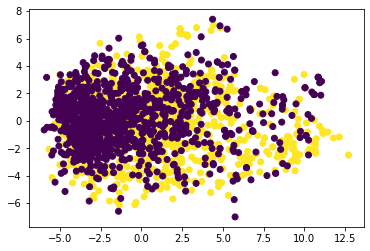

In [ ]:
plt.scatter(pos_neg_pca[:,0], pos_neg_pca[:,1], c=y_1000)

# **PART - e - logistic regression classifier**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(pos_neg_1000,y_1000)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred=lr.predict(pos_neg_100)

In [ ]:
accuracy = 0.0

for i in range(len(y_pred)):
  if y_pred[i] == y_100[i]:
    accuracy += 1.0

print("Accuracy = ", accuracy/ len(y_pred))

Accuracy =  0.69


# **Part - f - LSTM based text classifier**

In [83]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

LSTM_classifier = Sequential()

LSTM_classifier.add(Bidirectional(LSTM(100)))
LSTM_classifier.add(Flatten())
LSTM_classifier.add(Dense(100, activation = "relu"))
LSTM_classifier.add(Dense(2, activation = "softmax"))

In [ ]:
LSTM_classifier.compile(
    optimizer=Adam(), loss=sparse_categorical_crossentropy, metrics=["accuracy"]
)
LSTM_classifier.fit(pos_neg_1000_encoder_data, y_1000,
          batch_size=64,
          epochs=10,
          validation_split=0.2,verbose = 1)

In [86]:
accuracy = LSTM_classifier.evaluate(pos_neg_100_encoder_data , y_100)
print("Accuracy = " , accuracy[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.3723 - accuracy: 0.8700
Accuracy =  0.8700000047683716


In [88]:
LSTM_classifier.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_13 (ModuleWra (None, 200)               884000    
_________________________________________________________________
flatten_8 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 202       
Total params: 904,302
Trainable params: 904,302
Non-trainable params: 0
_________________________________________________________________
